<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D1%81%D0%B0%D0%BC%D0%BE%D0%BB%D1%91%D1%82%D0%BE%D0%B2_(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Импорт библиотек


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import scipy

import tensorflow.python.keras.backend as K

from tensorflow.python.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, LeakyReLU
from tensorflow.python.keras.layers import BatchNormalization, Add, add
from tensorflow.python.keras.layers import UpSampling2D, Conv2D

from tensorflow.python.platform.tf_logging import set_verbosity, FATAL
from tensorflow.python.keras.applications import vgg19

from keras.utils import plot_model
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam

#отключаем отображение некритических предупреждений
set_verbosity(FATAL)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'

##Загрузка данных

In [2]:
from google.colab import drive 
drive.mount('/content/drive')   #подключаем google drive, чтобы достать из него необходимый dataset

Mounted at /content/drive


In [3]:
img_shape = (256,384,3) #размер изображения
height=img_shape[0]
width=img_shape[1]

In [4]:
!unzip -q '/content/drive/My Drive/Базы/Airplanes.zip' #распаковываем базу

In [5]:
imgs = [] 
for image in sorted(os.listdir('img')): #проходим по каждому файлу, получаем список файлов в папке 
  print(image)
  imgs.append(img_to_array(load_img('img/'+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
imgs = np.stack(imgs).astype('uint8') #сохраняем итоговый массив изображений

masks = []
for image in sorted(os.listdir('mask')): #проходим по каждому файлу, получаем список файлов в папке 
  masks.append(img_to_array(load_img('mask/'+image, target_size=(height,width)))) #загружаем файл, устанавливаем нужный размер и сохраняем в оперативную память, как массив numpy
masks = np.stack(masks).astype('uint8') #сохраняем итоговый массив масок

airplane_1.jpg
airplane_10.jpg
airplane_100.jpg
airplane_1000.jpg
airplane_101.jpg
airplane_102.jpg
airplane_103.jpg
airplane_104.jpg
airplane_105.jpg
airplane_106.jpg
airplane_107.jpg
airplane_108.jpg
airplane_109.jpg
airplane_11.jpg
airplane_110.jpg
airplane_111.jpg
airplane_112.jpg
airplane_113.jpg
airplane_114.jpg
airplane_115.jpg
airplane_116.jpg
airplane_117.jpg
airplane_118.jpg
airplane_119.jpg
airplane_12.jpg
airplane_120.jpg
airplane_121.jpg
airplane_122.jpg
airplane_123.jpg
airplane_124.jpg
airplane_125.jpg
airplane_126.jpg
airplane_127.jpg
airplane_128.jpg
airplane_129.jpg
airplane_13.jpg
airplane_130.jpg
airplane_131.jpg
airplane_132.jpg
airplane_133.jpg
airplane_134.jpg
airplane_135.jpg
airplane_136.jpg
airplane_137.jpg
airplane_138.jpg
airplane_139.jpg
airplane_14.jpg
airplane_140.jpg
airplane_141.jpg
airplane_142.jpg
airplane_143.jpg
airplane_144.jpg
airplane_145.jpg
airplane_146.jpg
airplane_147.jpg
airplane_148.jpg
airplane_149.jpg
airplane_15.jpg
airplane_150.jpg
airp

##Создаём модель нейронной сети

###Создание генератора

In [6]:
def build_generator():
    gf = 64 #минимальное число фильтров
    

    def conv2d(layer_input, filters, f_size=4, bn=True): #слой с понижением разрешения (encoder)
        
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #strides = 2 уменьшает разрешение в 2 раза при padding='same'
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0): #слой с повышением разрешения (decoder) принимает на вход предыдущий слой и skip-слой от encoder'а
        u = UpSampling2D(size=2)(layer_input) #увеличивам разрешение в 2 раза
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u) #strides=1, padding='same',  поэтому разрешение сохраняется
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input]) #соединяем skip-слой и слой decoder'а
        return u

    
    d0 = Input(shape=img_shape, name="condition") #входное изображение (условие)

    # Часть encoder'a
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4) #чем меньше размер карт активаций
    d4 = conv2d(d3, gf*8) #тем больше должно быть фильтров в сверточном слое
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Часть decoder'a
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8) 
    u3 = deconv2d(u2, d4, gf*8) #чем больше размер карт активаций
    u4 = deconv2d(u3, d3, gf*4) #тем меньше должно быть фильтров в сверточном слое
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', name='G_output')(u7) #интенсивность должна быть от -1 до 1, поэтому используем tanh

    return Model(d0, output_img, name="G")

In [7]:
gen = build_generator() #создаем генератор
gen.summary()

Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 192, 64) 3136        condition[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 192, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 96, 128)  131200      leaky_re_lu[0][0]                
__________________________________________________________________________________________________

###Создание дискриминатора

In [8]:
def build_discriminator():
  
  df = 64 #минимальное число фильтров
  def d_layer(layer_input, filters, f_size=4, bn=True): #слой дискриминатора с понижением разрешения
      
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input) #размер карт активаций будет уменьшен в 2 раза, так как strides=2 при padding='same'
      d = LeakyReLU(alpha=0.2)(d)
      if bn:
          d = BatchNormalization(momentum=0.8)(d)
      return d

  image = Input(shape=img_shape, name="real_or_fake_A") #на вход дискриминатору подается либо реальное изображение, либо фейковое
  condition = Input(shape=img_shape, name="condition") #и дополнительно изображение-условие

  combined_imgs = Concatenate(axis=-1)([image, condition]) #объединяем оба входа в 1 слой

  d1 = d_layer(combined_imgs, df, bn=False)
  d2 = d_layer(d1, df*2)
  d3 = d_layer(d2, df*4) #уменьшаем размер карт активации, увеличивая их число
  d4 = d_layer(d3, df*8)

  validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='D_output', activation='sigmoid')(d4) #на выходе будет двумерный массив, каждый элемент которого определяет, подлинность части изображения (patch GAN)
                                                                                                            #0 отвечает за фейковые изображения, 1 за подлинные, поэтому используем sigmoid

  return Model([image, condition], validity, name='D')

In [9]:
dis = build_discriminator()
dis.summary()

Model: "D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
real_or_fake_A (InputLayer)     [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 256, 384, 6)  0           real_or_fake_A[0][0]             
                                                                 condition[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 192, 64) 6208        concatenate_6[0][0]              

###Создание VGG-модели для future loss

In [10]:
def build_vgg():
  #для feature loss создаем vgg модель
  vgg_in = Input(img_shape)
  vgg = vgg19.VGG19(include_top=False, input_shape=img_shape, input_tensor=vgg_in) #скачиваем архитектуру и веса 
  vgg_out = vgg.get_layer('block5_conv4').output #получаем последний сверточный слой
  vgg = Model(vgg_in, vgg_out, name='vgg')
  vgg.trainable = False #модель уже предобучена, поэтому ее необходимо заморозить

  return vgg

In [11]:
vgg = build_vgg()
vgg.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 192, 128)     147584    
________________________________________________________________

###Создание GAN

In [12]:
def build_gan(generator, discriminator, vgg):
  discriminator.trainable = False #замораживаем дискриминатор

  condition = Input(img_shape, name='Condition') #вход изображения-условия
  fake_img = generator(condition) #изображение, полученное от генератора

  fake_features = vgg(fake_img) #карты активации, полученные от фейкового изображения

  fake_validity = discriminator([fake_img, condition]) #соединяем генератор и дискриминатор

  gan = Model(condition, [fake_validity, fake_img, fake_features]) #получаем gan с тремя выходами: первый отвечает за "правдоподобность", второй за изображение от генератора, третий за карты активации

  return gan

###Проверяем размерности

In [13]:
dis.output_shape[1:]

(16, 24, 1)

In [14]:
(np.ones((128, *dis.output_shape[1:]))).shape

(128, 16, 24, 1)

##Тренируем модель

### Тренируем генератор и дискриминатор

In [15]:
def train(generator, discriminator, gan, vgg, imgs, masks, epochs, batch_size):

  for epoch in range(epochs): 
    idx = np.random.choice(imgs.shape[0], imgs.shape[0], replace=False) #перемешиваем индексы, чтобы batch'и всегда были разными

    with tqdm(total=imgs.shape[0]) as pbar: #для отслеживания создаем progressbar
      for batch in range(imgs.shape[0]//batch_size):
        
        #для тренировки дискриминатора применяем label smoothing
        #размерность Y: (размер батча, высота последнего слоя дискриминатора, ширина, 1)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:])) - np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2
        y_fake = np.random.random_sample((batch_size, *discriminator.output_shape[1:]))*0.2

        idx_batch = idx[batch*batch_size:(batch+1)*batch_size] #получаем индексы для одного batch'а

        real_imgs = (imgs[idx_batch]/127.5)-1 #получаем истинные изображения и нормализуем их
        condition = (masks[idx_batch]/127.5)-1 #получаем маски и нормализуем их

        fake_imgs = generator.predict(condition) #генерируем изображения по маскам

        #тренируем дискриминатор       
        d_loss_real = discriminator.train_on_batch([real_imgs, condition], y_real)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, condition], y_fake)
        d_loss_total = 0.5*np.add(d_loss_real, d_loss_fake)
   
        #тренируем генератор
        real_features = vgg.predict(real_imgs)
        y_real = np.ones((batch_size, *discriminator.output_shape[1:]))

        g_loss = gan.train_on_batch(condition, [y_real, real_imgs, real_features])
        pbar.update(batch_size) #обновляем progressbar
        pbar.set_description("Epoch: {}/{}, Discriminator loss: {}, Generator loss:{}".format(epoch+1, epochs, d_loss_total[0], g_loss))

In [16]:
gen = build_generator() #создаем генератор

dis = build_discriminator() #создаем дискриминатор
dis.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, beta_1=0.5), metrics=['accuracy'])

vgg = build_vgg() #создаем vgg модель

gan = build_gan(gen, dis, vgg) #создаем gan
gan.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1,100,10], optimizer=Adam(lr=1e-4, beta_1=0.5)) #вклад разницы между пикселями в 10 раз больше, чем вклад от feature loss и в 100 раз больше, чем вклад от GAN

###Параметры получившихся *моделей*

In [17]:
gen.summary() #параметры генератора

Model: "G"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 192, 64) 3136        condition[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 128, 192, 64) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 96, 128)  131200      leaky_re_lu_11[0][0]             
__________________________________________________________________________________________________

In [18]:
dis.summary() #параметры дискриминатора

Model: "D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
real_or_fake_A (InputLayer)     [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
condition (InputLayer)          [(None, 256, 384, 3) 0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 256, 384, 6)  0           real_or_fake_A[0][0]             
                                                                 condition[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 192, 64) 6208        concatenate_13[0][0]             

In [19]:
vgg.summary() #параметры vgg-модели

Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 96, 128)       0       

###Тренируем модель

In [20]:
train(gen, dis, gan, vgg, imgs, masks, 15, 16) #тренируем модель

Epoch: 1/15, Discriminator loss: 0.5034144371747971, Generator loss:[22.3809871673584, 1.4552987813949585, 0.2036563605070114, 0.05600504204630852]:  99%|█████████▉| 992/1000 [01:53<00:00,  8.76it/s]
Epoch: 2/15, Discriminator loss: 0.46980607509613037, Generator loss:[21.911468505859375, 1.8586626052856445, 0.1954384297132492, 0.05089643970131874]:  99%|█████████▉| 992/1000 [01:13<00:00, 13.46it/s]
Epoch: 3/15, Discriminator loss: 0.37481689453125, Generator loss:[18.75062370300293, 1.665188193321228, 0.16566835343837738, 0.05185997113585472]:  99%|█████████▉| 992/1000 [01:13<00:00, 13.47it/s]
Epoch: 4/15, Discriminator loss: 0.34430861473083496, Generator loss:[16.69908905029297, 1.0842585563659668, 0.15169422328472137, 0.04454069212079048]:  99%|█████████▉| 992/1000 [01:13<00:00, 13.48it/s]
Epoch: 5/15, Discriminator loss: 0.3848811537027359, Generator loss:[18.880647659301758, 2.320127248764038, 0.16078583896160126, 0.04819362238049507]:  99%|█████████▉| 992/1000 [01:13<00:00, 13.5

##Визуализация результатов работы сети

In [21]:
def sample_image(generator, imgs, masks, idx): #отображаем маску, созданное и исходное изображения
    fig, ax = plt.subplots(1,3, figsize=(15,5)) #создаем сетку с 1 строкой и 3 столбцами


    ax[0].imshow(masks[idx]) #показываем маску
    ax[0].set_title('маска')
    
    condition = masks[idx]/127.5-1
    generated = (generator.predict(condition[None])+1)*127.5 #по маске генерируем изображение

    ax[1].imshow(generated[0].astype('uint8')) #показываем сгенерированное изображение
    ax[1].set_title('сгенерированное изображение')

    ax[2].imshow(imgs[idx]) #показываем исходное изображение
    ax[2].set_title('реальное изображение')

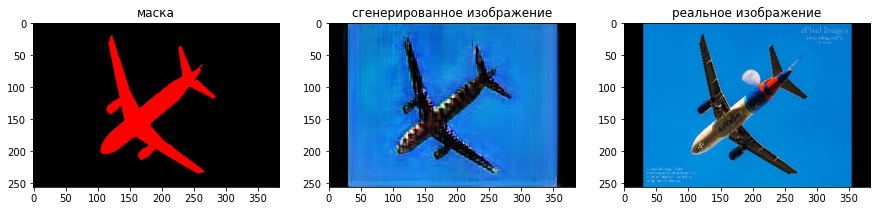

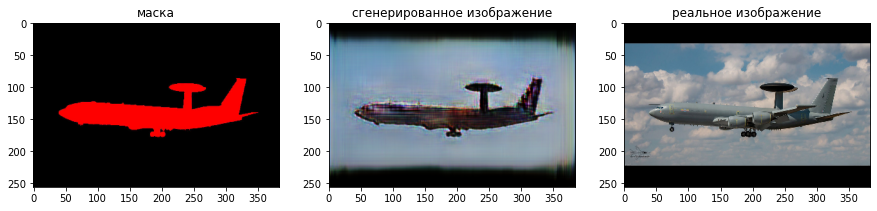

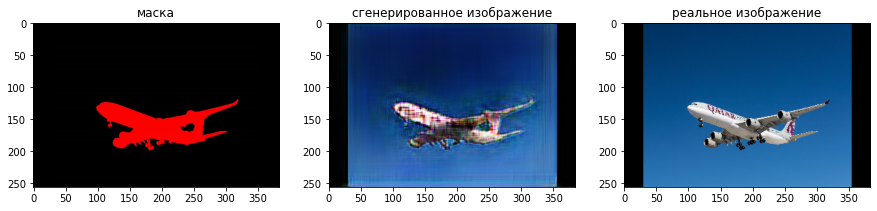

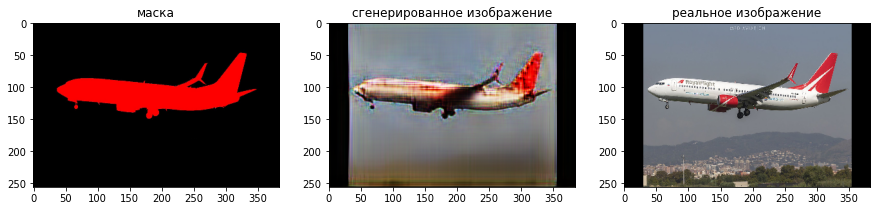

In [22]:
for i in [20,100,300,500]:
   sample_image(gen, imgs, masks, i)